In [1]:
from __future__ import print_function,division,absolute_import,unicode_literals
import numpy as np
np.random.seed(1337)

In [2]:
import tensorflow as tf

In [3]:
import os
import json

In [4]:
# the first part is the face localzation, we used the public face locilization mobilenet-ssd for it. 
# the class was trained in the WIDER -face fataset, current susyem has mAcx = 0.63 with mAP= 0.738, avg inference = .0012 

class TensoflowMobilNetSSDFaceDector():
    def __init__(self,
                 det_threshold=0.5,
                 model_path='models/ssd/frozen_inference_graph_face.pb'):

        self.det_threshold = det_threshold
        self.detection_graph = tf.Graph()
        with self.detection_graph.as_default():
            od_graph_def = tf.GraphDef()
            with tf.gfile.GFile(model_path, 'rb') as fid:
                serialized_graph = fid.read()
                od_graph_def.ParseFromString(serialized_graph)
                tf.import_graph_def(od_graph_def, name='')
     
        with self.detection_graph.as_default():
            config = tf.ConfigProto()
            config.gpu_options.allow_growth = True
            self.sess = tf.Session(graph=self.detection_graph, config=config)

    def detect_face(self, image):

        h, w, c = image.shape

        image_np = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        image_np_expanded = np.expand_dims(image_np, axis=0)
        image_tensor = self.detection_graph.get_tensor_by_name(
            'image_tensor:0')

        boxes = self.detection_graph.get_tensor_by_name('detection_boxes:0')

        scores = self.detection_graph.get_tensor_by_name('detection_scores:0')
        classes = self.detection_graph.get_tensor_by_name(
            'detection_classes:0')
        num_detections = self.detection_graph.get_tensor_by_name(
            'num_detections:0')

        (boxes, scores, classes, num_detections) = self.sess.run(
            [boxes, scores, classes, num_detections],
            feed_dict={image_tensor: image_np_expanded})

        boxes = np.squeeze(boxes)
        scores = np.squeeze(scores)

        filtered_score_index = np.argwhere(
            scores >= self.det_threshold).flatten()
        selected_boxes = boxes[filtered_score_index]

        faces = np.array([[
            int(x1 * w),
            int(y1 * h),
            int(x2 * w),
            int(y2 * h),
        ] for y1, x1, y2, x2 in selected_boxes])

        return faces

In [5]:
#initlize the localization object
face_detector = TensoflowMobilNetSSDFaceDector()

In [14]:
#checking the single face for detection

#img_file_path = 'istockphoto-1007763808-612x612.jpg'
img_file_path = 'recog_files/data/train/bruce/003.jpg'

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

In [16]:
image = cv2.imread(img_file_path,cv2.COLOR_BGR2RGB)
print(image.shape)

(250, 250, 3)


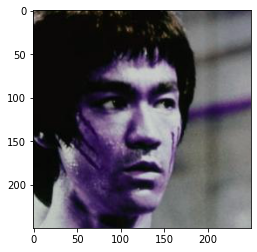

In [17]:
plt.imshow(image)

In [18]:
pred = face_detector.detect_face(image)
pred = pred[0]
print(pred)

[ 38  29 164 240]


In [19]:
face_img = image[pred[1] : pred[3], pred[0] : pred[2]]

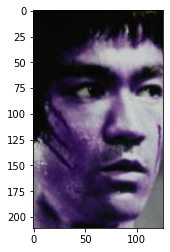

In [20]:
plt.imshow(face_img)

In [21]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, Activation, Input, Add
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import MaxPooling2D

In [22]:
class FaceFeatureExtract():
    def __init__(self,model_weight='models/face/deepid_keras_weights.h5'):
        self.model_weight = model_weight
        self.model = self._make_model()
        
    def _make_model(self):
        myInput = Input(shape=(55, 47, 3))
        x = Conv2D(20, (4, 4), name='Conv1', activation='relu', input_shape=(55, 47, 3))(myInput)
        x = MaxPooling2D(pool_size=2, strides=2, name='Pool1')(x)
        x = Dropout(rate=.5, name='D1')(x)
 
        x = Conv2D(40, (3, 3), name='Conv2', activation='relu')(x)
        x = MaxPooling2D(pool_size=2, strides=2, name='Pool2')(x)
        x = Dropout(rate=.5, name='D2')(x)
 
        x = Conv2D(60, (3, 3), name='Conv3', activation='relu')(x)
        x = MaxPooling2D(pool_size=2, strides=2, name='Pool3')(x)
        x = Dropout(rate=.5, name='D3')(x)
 
        x1 = Flatten()(x)
        fc11 = Dense(160, name = 'fc11')(x1)
 
        x2 = Conv2D(80, (2, 2), name='Conv4', activation='relu')(x)
        x2 = Flatten()(x2)
        fc12 = Dense(160, name = 'fc12')(x2)
 
        y = Add()([fc11, fc12])
        y = Activation('relu', name = 'deepid')(y)
 
        model = Model(inputs=[myInput], outputs=y)

        #model.summary()

        model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
        model.load_weights(self.model_weight)
        
        
        return model
    
    def make_face_features(self,image):
        face_pixels = cv2.resize(image,(55, 47),cv2.INTER_AREA)
        # scale pixel values
        face_pixels = face_pixels.astype('float32')
        # standardize pixel values across channels (global)
        mean, std = face_pixels.mean(), face_pixels.std()
        face_pixels = (face_pixels - mean) / std
        # scale pixel values
        face_pixels = face_pixels.astype('float32')
        # standardize pixel values across channels (global)
        mean, std = face_pixels.mean(), face_pixels.std()
        face_pixels = (face_pixels - mean) / std
        face_pixels = np.reshape(face_pixels,(1,55,47,3))
        pred = self.model.predict(face_pixels)
        
        return np.reshape(pred,(160,))

In [23]:
face_feature_extractor = FaceFeatureExtract()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [24]:
adrina_face_features = face_feature_extractor.make_face_features(face_img)

In [25]:
print(adrina_face_features.shape,adrina_face_features)

(160,) [  0.          0.          0.         74.44979     0.          0.
  84.752785    0.          0.          0.        120.47532    24.392574
  85.49326     0.          4.1103497  26.538015    0.          0.
  85.142525   16.347263  113.569244   14.108999    0.          0.
   0.          6.638727    0.          0.          0.          0.
   0.          0.          0.         25.82126    35.89273    49.141098
  25.296494    6.636347    0.         73.32429     0.        107.12905
  15.184212    0.          0.          0.          0.          0.
   0.          1.6804237 110.54863     0.          0.          0.
   0.          6.519018    0.          7.2573204   0.         32.02875
   0.          0.          0.        132.42113     0.          0.
   0.         43.97384   111.96684     0.          0.          0.
   5.37006    22.59216     0.         36.868275   37.61006     0.
  34.665115   92.44439    58.970085    0.         13.915899   35.222244
  45.03636     0.        107.96922     0.

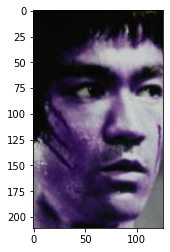

In [26]:
plt.imshow(np.array(face_img))

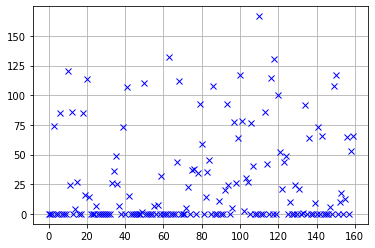

In [27]:
plt.plot(adrina_face_features,'bx')
plt.grid(True)

(250, 250, 3)
[ 54  49 190 196]


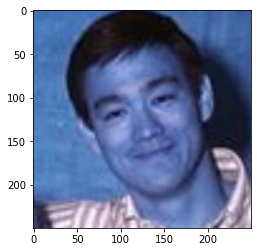

In [28]:
image = cv2.imread('recog_files/data/train/bruce/008.jpg',cv2.COLOR_BGR2RGB)
print(image.shape)

plt.imshow(image)

pred = face_detector.detect_face(image)
pred = pred[0]
print(pred)
face_img_2 = image[pred[1] : pred[3], pred[0] : pred[2]]

In [29]:
adrina_face_features_2 = face_feature_extractor.make_face_features(face_img_2)

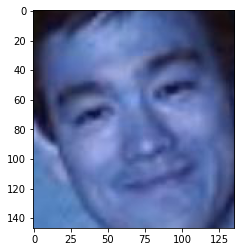

In [30]:
plt.imshow(np.array(face_img_2))

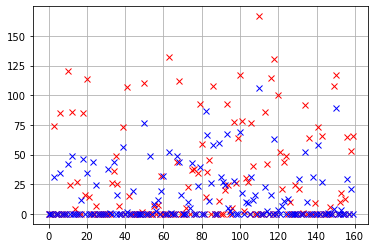

In [31]:
plt.plot(adrina_face_features,'rx')
plt.plot(adrina_face_features_2,'bx')
plt.grid(True)

In [32]:
from numpy import dot
from numpy.linalg import norm


def cosine_distance_my(a,b):
    return dot(a, b)/(norm(a)*norm(b))

def cosine_distance_annoy(u,v):
    return np.sqrt(2-2*np.dot(u,v))

In [33]:
print(cosine_distance_my(adrina_face_features,adrina_face_features_2))

0.753576


In [36]:
class Facenet():
    def __init__(self,model_path ='models/facenet/model/facenet_keras.h5',
                 model_weight='models/facenet/weights/facenet_keras_weights.h5'):
        self.model_weight = model_weight
        self.model_path = model_path
        self.model = self._make_model()
        
    def _make_model(self):
        model = load_model(self.model_path)

        #model.summary()

        model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
        model.load_weights(self.model_weight)
        
        
        return model
    
    def make_face_features(self,image):
        face_pixels = cv2.resize(image,(160,160),cv2.INTER_AREA)
        # scale pixel values
        face_pixels = face_pixels.astype('float32')
        # standardize pixel values across channels (global)
        mean, std = face_pixels.mean(), face_pixels.std()
        face_pixels = (face_pixels - mean) / std
        # scale pixel values
        face_pixels = face_pixels.astype('float32')
        # standardize pixel values across channels (global)
        mean, std = face_pixels.mean(), face_pixels.std()
        face_pixels = (face_pixels - mean) / std
        face_pixels = np.reshape(face_pixels,(1,160,160,3))
        pred = self.model.predict(face_pixels)
        
        return np.reshape(pred,(128,))

In [37]:
facenet = Facenet()

In [38]:
bruve1 = facenet.make_face_features(face_img)
bruve2 = facenet.make_face_features(face_img_2)

0.56641525


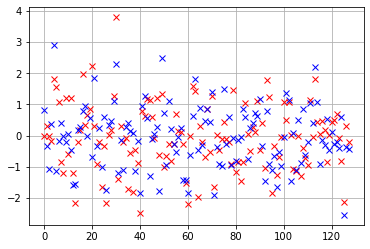

In [39]:
plt.plot(bruve1,'rx')
plt.plot(bruve2,'bx')
plt.grid(True)
print(cosine_distance_my(bruve1,bruve2))

In [45]:
image = cv2.imread('recog_files/data/train/dana/008.jpg',cv2.COLOR_BGR2RGB)
print(image.shape)
pred = face_detector.detect_face(image)
pred = pred[0]
print(pred)

(250, 250, 3)
[ 53  37 195 211]


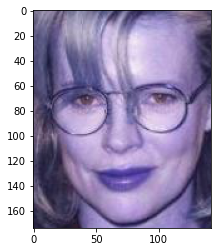

In [46]:
face_img = image[pred[1] : pred[3], pred[0] : pred[2]]
plt.imshow(face_img)

In [47]:
image = cv2.imread('recog_files/data/train/dana/008.jpg',cv2.COLOR_BGR2RGB)
print(image.shape)
pred = face_detector.detect_face(image)
pred = pred[0]
print(pred)
face_img = image[pred[1] : pred[3], pred[0] : pred[2]]
plt.imshow(face_img)
bruve3 = facenet.make_face_features(face_img)

0.007012244


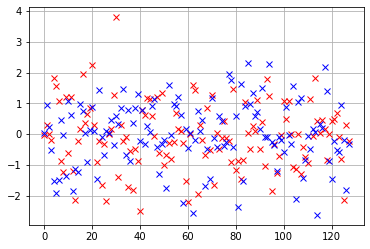

In [48]:
plt.plot(bruve1,'rx')
plt.plot(bruve3,'bx')
plt.grid(True)
print(cosine_distance_my(bruve1,bruve3))

In [52]:
file_dir = os.listdir('recog_files/data/train/alice/')

In [53]:
features_list = []
for file in file_dir:
    print(file)
    image = cv2.imread(img_file_path,cv2.COLOR_BGR2RGB)
    pred = face_detector.detect_face(image)
    print(pred[0])
    if len(pred[0]) == 0:
        face_img = image
    else:
        pred = pred[0]
        face_img = image[pred[1] : pred[3], pred[0] : pred[2]]
    print(face_img.shape)
    features = facenet.make_face_features(face_img)
    print(features.shape)
    features_list.append(features)

002.jpg
[ 38  29 164 240]
(211, 126, 3)
(128,)
003.jpg
[ 38  29 164 240]
(211, 126, 3)
(128,)
004.jpg
[ 38  29 164 240]
(211, 126, 3)
(128,)
005.jpg
[ 38  29 164 240]
(211, 126, 3)
(128,)
007.jpg
[ 38  29 164 240]
(211, 126, 3)
(128,)
013.jpg
[ 38  29 164 240]
(211, 126, 3)
(128,)
014.jpg
[ 38  29 164 240]
(211, 126, 3)
(128,)
017.jpg
[ 38  29 164 240]
(211, 126, 3)
(128,)
022.jpg
[ 38  29 164 240]
(211, 126, 3)
(128,)
023.jpg
[ 38  29 164 240]
(211, 126, 3)
(128,)
025.jpg
[ 38  29 164 240]
(211, 126, 3)
(128,)
028.jpg
[ 38  29 164 240]
(211, 126, 3)
(128,)
029.jpg
[ 38  29 164 240]
(211, 126, 3)
(128,)
030.jpg
[ 38  29 164 240]
(211, 126, 3)
(128,)
061.jpg
[ 38  29 164 240]
(211, 126, 3)
(128,)


In [54]:
features_list = np.asarray(features_list)

In [55]:
features_list.shape

(15, 128)

In [64]:
dir_path = 'recog_files/data/train/'
name_list = os.listdir('recog_files/data/train/')

In [111]:
for idx,name in enumerate(name_list):
    file_dir = os.listdir(str(dir_path+name+'/'))
    for file in file_dir:
        print(file)
        image = cv2.imread(img_file_path,cv2.COLOR_BGR2RGB)
        pred = face_detector.detect_face(image)
        print(pred[0])
        if len(pred[0]) == 0:
            face_img = image
        else:
            pred = pred[0]
            face_img = image[pred[1] : pred[3], pred[0] : pred[2]]
        print(face_img.shape)
        features = facenet.make_face_features(face_img)
        print(name,idx,features.shape)
        t.add_item(idx,features)

002.jpg
[ 38  29 164 240]
(211, 126, 3)
alice 0 (128,)
003.jpg
[ 38  29 164 240]
(211, 126, 3)
alice 0 (128,)
004.jpg
[ 38  29 164 240]
(211, 126, 3)
alice 0 (128,)
005.jpg
[ 38  29 164 240]
(211, 126, 3)
alice 0 (128,)
007.jpg
[ 38  29 164 240]
(211, 126, 3)
alice 0 (128,)
013.jpg
[ 38  29 164 240]
(211, 126, 3)
alice 0 (128,)
014.jpg
[ 38  29 164 240]
(211, 126, 3)
alice 0 (128,)
017.jpg
[ 38  29 164 240]
(211, 126, 3)
alice 0 (128,)
022.jpg
[ 38  29 164 240]
(211, 126, 3)
alice 0 (128,)
023.jpg
[ 38  29 164 240]
(211, 126, 3)
alice 0 (128,)
025.jpg
[ 38  29 164 240]
(211, 126, 3)
alice 0 (128,)
028.jpg
[ 38  29 164 240]
(211, 126, 3)
alice 0 (128,)
029.jpg
[ 38  29 164 240]
(211, 126, 3)
alice 0 (128,)
030.jpg
[ 38  29 164 240]
(211, 126, 3)
alice 0 (128,)
061.jpg
[ 38  29 164 240]
(211, 126, 3)
alice 0 (128,)
001.jpg
[ 38  29 164 240]
(211, 126, 3)
bruce 1 (128,)
002.jpg
[ 38  29 164 240]
(211, 126, 3)
bruce 1 (128,)
003.jpg
[ 38  29 164 240]
(211, 126, 3)
bruce 1 (128,)
006.jpg
[ 

In [73]:
features_list

[array([-2.5231630e-02,  3.0959916e-01, -1.0583248e-02, -1.8734400e-01,
         1.8241327e+00,  1.5486568e+00,  1.0697645e+00, -8.6082822e-01,
        -1.2171437e+00,  1.1953484e+00, -6.0036021e-01,  1.2012553e+00,
        -1.2044780e+00, -2.1500371e+00, -2.1865165e-01,  1.8038966e-01,
         1.9622254e+00,  3.4728813e-01,  6.5583080e-01,  8.4000957e-01,
         2.2344482e+00,  3.1348422e-01, -9.1969359e-01, -2.1841419e-01,
        -1.6477880e+00, -3.2120466e-01, -2.1549239e+00,  2.3072958e-03,
         1.7640835e-01,  1.2666202e+00,  3.7951026e+00, -1.3894651e+00,
         3.1181240e-01, -2.1292683e-01, -7.6715931e-02, -1.7111492e+00,
        -5.5122542e-01, -1.8037874e+00, -4.7151065e-01, -8.7385070e-01,
        -2.4882185e+00,  7.8731489e-01,  6.2651873e-01,  1.1819651e+00,
         1.1392709e+00,  5.9887308e-01, -7.4894920e-02,  1.1972437e+00,
        -6.2634075e-01,  1.3214376e+00, -1.0018023e+00, -6.6726124e-01,
        -2.7561569e-01, -8.2057649e-01, -2.6336667e-01,  6.89932

In [112]:
from annoy import AnnoyIndex

In [99]:
t = AnnoyIndex(128, 'dot')

In [113]:
t.build(10) # 10 trees
t.save('recog_files/data/test.ann')

Exception: You can't build a built index

In [114]:
t.get_nns_by_vector(bruve3,1, search_k=-1, include_distances=True)

([0], [0.9997620582580566])

(250, 250, 3)
[ 53  37 195 211]


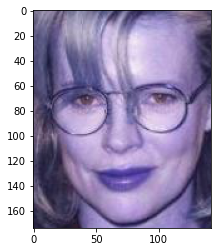

In [132]:
img = cv2.imread('recog_files/data/train/dana/008.jpg',cv2.COLOR_BGR2RGB)
print(image.shape)
pred = face_detector.detect_face(img)
pred = pred[0]
print(pred)
face_img = img[pred[1] : pred[3], pred[0] : pred[2]]
plt.imshow(face_img)
feat1 = facenet.make_face_features(face_img)

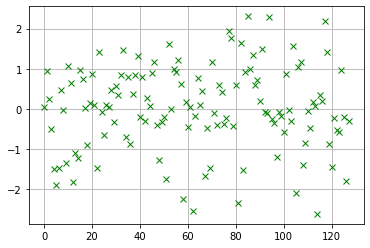

In [133]:
plt.plot(feat1,'gx')
plt.grid(True)

(250, 250, 3)
[ 58  42 191 219]


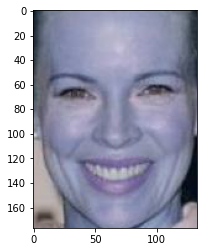

In [135]:
img = cv2.imread('recog_files/data/train/dana/004.jpg',cv2.COLOR_BGR2RGB)
print(image.shape)
pred = face_detector.detect_face(img)
pred = pred[0]
print(pred)
face_img = img[pred[1] : pred[3], pred[0] : pred[2]]
plt.imshow(face_img)
feat2 = facenet.make_face_features(face_img)

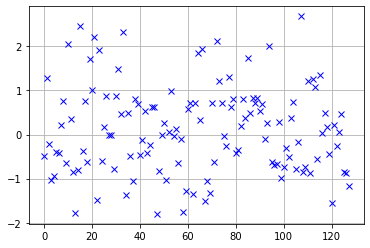

In [136]:
plt.plot(feat2,'bx')
plt.grid(True)

In [137]:
print(cosine_distance_my(feat1,feat2))

0.6143912


In [138]:
from panns import *

SyntaxError: invalid syntax (index.py, line 24)